http://www.diva-portal.org/smash/get/diva2:518434/FULLTEXT01.pdf

In [10]:
from VRPTW import *
import os

from ipynb.fs.defs.draw_solution import *

if not os.path.exists('solutions'):
    os.mkdir('solutions')

## Constants

In [11]:
PROBLEM_FILE = "instances/C108.txt"

## Create problem

In [12]:
assert os.path.exists(PROBLEM_FILE), "Problem file doesn't exist"
problem = SolomonFormatParser(PROBLEM_FILE).get_problem()
print(problem)

Instance: C108
Vehicle number: 25
Vehicle capacity: 200



## Solve the problem

In [13]:
solution = IteratedLocalSearch(problem).execute()
with open(f"""solutions/{PROBLEM_FILE.split(os.sep)[-1].split(".")[0]}.sol""", 'w') as f:
    f.write(problem.print_canonical(solution))
# solution = GuidedLocalSearch(problem).execute()

Local search solution:
0 0.0 65 12.806248474865697 5 128.51616873923058 98 237.38413100334378 27 369.26491418608765 29 462.87046546155165 30 557.8704654615517 28 650.8704654615517 48 766.3655630295157 51 859.3655630295157 50 951.6016310070155 52 1044.7639086671838 0 1155.9771121027802
0 0.0 17 33.301651610693426 57 187.20783284537526 55 279.20783284537526 62 390.74849207391327 74 483.74849207391327 72 578.7484920739132 60 699.554335675412 68 816.4801597110845 66 911.865324518219 1 1034.925875027852 0 1143.6074167201214
0 0.0 87 25.495097567963924 20 150.8504366272913 43 256.14749516806967 40 351.5326599752042 10 477.5326599752042 11 570.5326599752042 85 694.7379227281783 88 787.7379227281783 89 880.5663498529245 21 1004.1073695154214 49 1111.2246122840452 0 1220.4339849963437
0 0.0 67 12.206555615733702 90 122.05598885701292 13 254.9978099641807 18 351.9978099641807 19 446.9978099641807 38 579.7178286907684 39 674.7178286907684 36 769.7178286907684 34 862.7178286907684 22 973.907448791

## Draw the solution

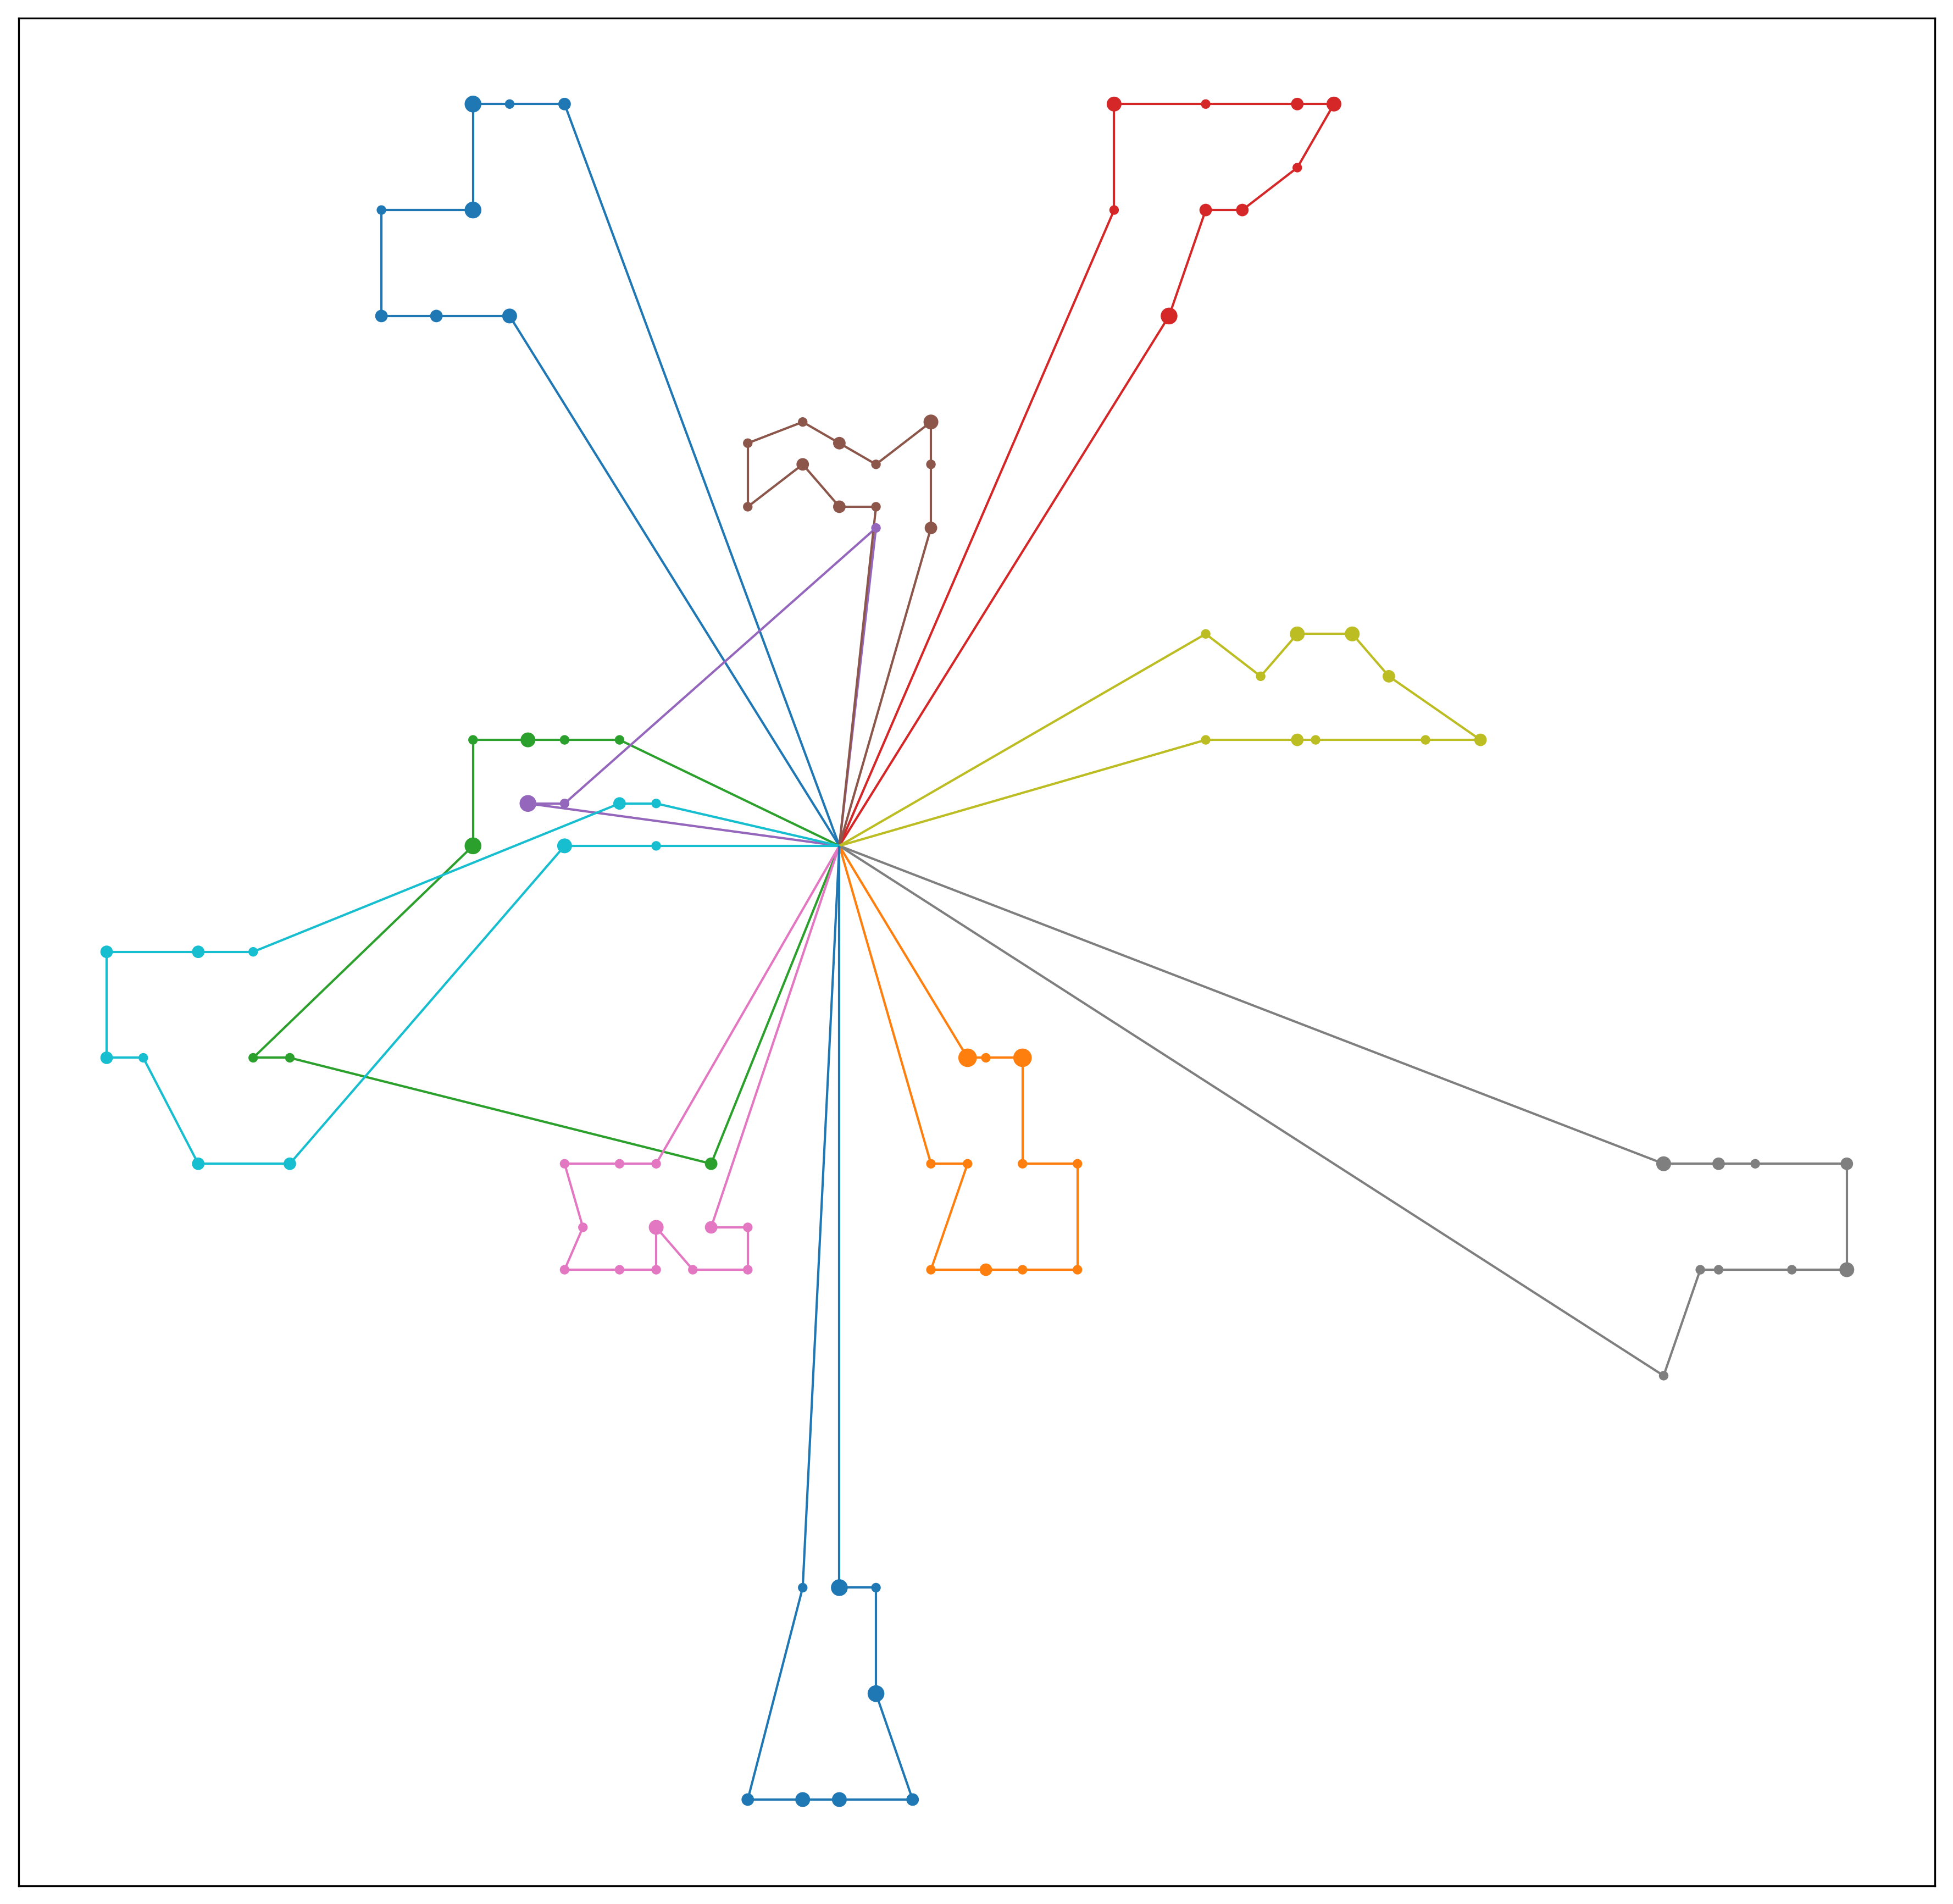

In [18]:
draw_solution(PROBLEM_FILE, problem.print_canonical(solution).split('\n'))

In [ ]:
# !pip install jmetalpy

In [ ]:
from jmetal.algorithm.multiobjective import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.problem import ZDT1
from jmetal.util.termination_criterion import StoppingByEvaluations

problem = ZDT1()

algorithm = NSGAII(
    problem=problem,
    population_size=100,
    offspring_population_size=100,
    mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations=25000)
)

algorithm.run()
front = get_non_dominated_solutions(algorithm.get_result())

plot_front = Plot(title='Pareto front approximation', axis_labels=['x', 'y'])
plot_front.plot(front, label='NSGAII-ZDT1', filename='NSGAII-ZDT1', format='png')

In [ ]:
def cross(a, b, i, j):
    return a[:i] + b[j:], b[:j] + a[i:]


def insertion(a, b, i, j):
    # print(a, b, i, j)
    if len(a) == 0:
        return a, b
    while i >= len(a):
        i -= len(a)
    return a[:i] + a[i + 1:], b[:j] + [a[i]] + b[j:]


def swap(a, b, i, j):
    # print(a, b, i, j)
    if i >= len(a) or j >= len(b):
        return a, b
    a, b = a.copy(), b.copy()
    a[i], b[j] = b[j], a[i]
    return a, b

In [ ]:
from jmetal.core.problem import FloatProblem, FloatSolution
from math import sqrt

class VRP(FloatProblem):
    """ Problem VRP.
    
    IDK
    
    .. note:: Bi-objective unconstrained problem. The default number of variables is 30.
    .. note:: Continuous problem having a convex Pareto front
    """

    def __init__(self, number_of_variables: int=30):
        """ :param number_of_variables: Number of decision variables of the problem.
        """
        super(VRP, self).__init__()
        self.number_of_variables = number_of_variables
        self.number_of_objectives = 2
        self.number_of_constraints = 0

        self.obj_directions = [self.MINIMIZE, self.MINIMIZE]
        self.obj_labels = ['x', 'y']

        self.lower_bound = self.number_of_variables * [0.0]
        self.upper_bound = self.number_of_variables * [1.0]

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        g = self.eval_g(solution)
        h = self.eval_h(solution.variables[0], g)

        solution.objectives[0] = solution.variables[0]
        solution.objectives[1] = h * g

        return solution

    def eval_g(self, solution: FloatSolution):
        g = sum(solution.variables) - solution.variables[0]

        constant = 9.0 / (solution.number_of_variables - 1)

        return constant * g + 1.0

    def eval_h(self, f: float, g: float) -> float:
        return 1.0 - sqrt(f / g)

    def get_name(self):
        return 'VRP'

In [ ]:
from jmetal.algorithm.multiobjective import MOCell
from jmetal.operator import PolynomialMutation, SBXCrossover
from jmetal.problem import ZDT1
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.neighborhood import C9
from jmetal.util.archive import CrowdingDistanceArchive

from jmetal.util.solution import get_non_dominated_solutions
from jmetal.lab.visualization import Plot

problem = VRP()

algorithm = MOCell(
    problem=problem,
    population_size=100,
    neighborhood=C9(3, 3),
    archive=CrowdingDistanceArchive(100),
    mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations=25000)
)

algorithm.run()

front = get_non_dominated_solutions(algorithm.get_result())

plot_front = Plot(title='Pareto front approximation', axis_labels=['x', 'y'])
plot_front.plot(front, label='MOCell-VRP', filename='MOCell-VRP', format='png')

In [ ]:
from VRPTW.parser import SolomonFormatParser

problem = SolomonFormatParser("instances/C108.txt").get_problem()
problem

In [ ]:
C9?